# Parameter covariance (or lack thereof) of PCA and KL decompositions

In [12]:
# Show plots inline, and load main getdist plot module and samples class
#Change
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1
# import libraries:
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import IPython
from IPython.display import Markdown
import numpy as np
import seaborn as sns
# import the tensiometer tools that we need:
from Tensiometer.tensiometer import utilities
from Tensiometer.tensiometer import gaussian_tension

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Could not import tensorflow or tensorflow_probability:  No module named 'tensorflow_probability'


In [15]:
# load the chains (remove no burn in since the example chains have already been cleaned):
chains_dir = '/Users/TaraD/MeasuredCosmoParameters/Tensiometer/test_chains/' #'./../../test_chains/'
# the DES Y1 3x2 chain:
settings = {'ignore_rows':0, 'smooth_scale_1D':0.3, 'smooth_scale_2D':0.3}
chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'DES', no_cache=True, settings=settings)
#chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'Planck18TTTEEE', no_cache=True, settings=settings)

# the prior chain:
prior_chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'prior', no_cache=True, settings=settings)
# we add a couple of derived parameters that have been removed from the chains (to save a little space on github):
for ch in [chain, prior_chain]:
    p = ch.getParams()
    ch.addDerived(p.omegach2/(p.H0/100.)**2, name='omegac', label='\\Omega_c')
    ch.addDerived(p.omegabh2/(p.H0/100.)**2, name='omegab', label='\\Omega_b')
    ch.addDerived(p.sigma8*np.sqrt(p.omegam/0.3), name='S8', label='S_8')
    ch.addDerived(p.sigma8*5, name='sigma8_5', label='\\sigma_8 5')
    ch.addDerived(p.omegam - (p.omegabh2/(p.H0/100.)**2) , name='omegac_derived', label='\\Omega_{c,derived}')

    ch.updateBaseStatistics()


In [16]:
param_names = chain.getParamNames().getRunningNames()

param_names = ['omegam', 'omegab', 'sigma8', 'ns', 'H0']



In [17]:
for ch in [chain, prior_chain]:
    p = ch.getParams()
    ch.addDerived(np.log(p.omegam), name='log_omegam', label='\\log \\Omega_m')
    ch.addDerived(np.log(p.omegab), name='log_omegab', label='\\log \\Omega_b')
    ch.addDerived(np.log(p.sigma8), name='log_sigma8', label='\\log \\sigma_8')
    ch.addDerived(np.log(p.ns), name='log_ns', label='\\log n_s')
    ch.addDerived(np.log(p.H0), name='log_H0', label='\\log H_0')
    
    # changed
    ch.addDerived(np.log(p.logA), name='log_logA', label='\\log \\logA')
    ch.addDerived(np.log(p.sigma8_5), name='log_sigma8_5', label='\\log \\sigma_8 5')
    #ch.addDerived(np.log(p.omegac), name='log_omegac', label='\\log \\Omega_c')
    #ch.addDerived(np.log(p.omegac_derived), name='log_omegac_derived', label='\\log \\Omega_{c,derived}')
    #
    ch.updateBaseStatistics()

In [18]:
print(param_names)

['omegam', 'omegab', 'sigma8', 'ns', 'H0']


In [95]:
print(type(chain))
#print(chain.getParamNames())
print(param_names)
#print(chain.index['log_omegam'])
KL_param_names = ['log_'+name for name in param_names]
print(KL_param_names)

# Need this line for chain indexing to fully work for some reason (revisit why later):
#KL_eig, KL_eigv, KL_param_names = gaussian_tension.Q_UDM_KL_components(prior_chain, chain, param_names=KL_param_names)

print(chain.index['log_omegam'])

#cov = np.array(chain.getCov())
#mean = np.reshape(chain.getMeans(), (len(chain.getMeans()),1))
#print(np.shape(cov))
#print(np.shape(mean))
#Gauss = MixtureND(mean,cov)
#chain_gauss = Gauss.MCSamples()

Gauss = gaussian_tension.gaussian_approximation(chain, param_names=KL_param_names)
chain_gauss = Gauss.MCSamples(size = 100000)
prior_gauss = gaussian_tension.gaussian_approximation(prior_chain, param_names=KL_param_names)
prior_chain_gauss = prior_gauss.MCSamples(size = 100000)

#prior_cov = prior_chain.getCov()
#prior_mean = chain.getMeans()
#prior_Gauss = MixtureND(mean,cov)
#prior_chain_gauss = Gauss.MCSamples()

##### MR after generating the two perfectly Gaussian chains we can compute here the other parameters as derived:
for ch in [chain_gauss, prior_chain_gauss]:
    
    p = ch.getParams()
    ch.addDerived(np.exp(p.log_omegam), name='omegam', label='\\Omega_m')
    # and so on...
    
    # we can also add here Omegac so that we can get the different KLs easily
    ch.addDerived(np.exp(p.log_omegab), name='omegab', label='\\Omega_b')
    ch.addDerived(np.exp(p.log_sigma8), name='sigma8', label='\\sigma_8')
    ch.addDerived(np.exp(p.log_ns), name='ns', label='\\n_s')
    ch.addDerived(np.exp(p.log_H0), name='H0', label='\\H_0')
    
    ch.updateBaseStatistics()

for ch in [chain_gauss, prior_chain_gauss]:
    p = ch.getParams()
    ch.addDerived(p.omegam - p.omegab , name='omegac_derived', label='\\Omega_{c,derived}')
    
    #ch.addDerived( - (np.exp(p.log_omegab)/(np.exp(p.log_H0)/100.)**2) , name='omegac_derived', label='\\Omega_{c,derived}')
    #ch.addDerived(np.log(np.exp(p.log_omegam) - (np.exp(p.log_omegab)/(np.exp(p.log_H0)/100.)**2)) , name='log_omegac_derived', label='\\log \\Omega_{c,derived}')

    ch.updateBaseStatistics()
    
print(len((ch.getParams().omegac_derived)[ch.getParams().omegac_derived<=0]))

for ch in [chain_gauss, prior_chain_gauss]: 
    p = ch.getParams()
    
    ch.addDerived(np.log(p.omegac_derived), name='log_omegac_derived', label='\\log \\Omega_{c,derived}')
    
    ch.updateBaseStatistics()

<class 'getdist.mcsamples.MCSamples'>
['omegam', 'omegab', 'sigma8', 'ns', 'H0']
['log_omegam', 'log_omegab', 'log_sigma8', 'log_ns', 'log_H0']
17
950


<ipython-input-95-71cc5440f5b1>:59: RuntimeWarning: invalid value encountered in log
  ch.addDerived(np.log(p.omegac_derived), name='log_omegac_derived', label='\\log \\Omega_{c,derived}')


# Running with Gaussian chains

In [66]:
param_names_gauss = ['omegam', 'omegab', 'sigma8', 'ns', 'H0']
print(param_names_gauss)
KL_param_names_gauss = ['log_'+name for name in param_names_gauss]
print(KL_param_names_gauss)
# compute the KL modes:
KL_eig, KL_eigv, KL_param_names_gauss = gaussian_tension.Q_UDM_KL_components(prior_chain_gauss, chain_gauss, param_names=KL_param_names_gauss)
# print:
with np.printoptions(precision=2, suppress=True):
    print('Improvement factor over the prior:', KL_eig)
    print('Improvement in error units:', np.sqrt(KL_eig-1))
    
# do the PCA on the log parameters:
#print(chain)

PCA_param_names = ['log_'+name for name in param_names_gauss]
# compute the PCA modes:
#PCA_eig, PCA_eigv, PCA_param_names = 
#PCA_out = chain_gauss.PCA(KL_param_names)
#print(PCA_out)

# print:
#with np.printoptions(precision=2, suppress=True):
#    print('Improvement factor over the prior:', PCA_eig)
#    print('Improvement in error units:', np.sqrt(PCA_eig-1))


['omegam', 'omegab', 'sigma8', 'ns', 'H0']
['log_omegam', 'log_omegab', 'log_sigma8', 'log_ns', 'log_H0']
Improvement factor over the prior: [1415.99   51.22   31.55    1.34    1.12]
Improvement in error units: [37.62  7.09  5.53  0.59  0.35]


In [67]:
PCA_eig, PCA_eigv = np.linalg.eigh(chain_gauss.cov(KL_param_names_gauss))
print(PCA_eig)

[0.00052009 0.00133478 0.0155105  0.03394184 0.12121204]


In [ ]:
# First we compute the fractional Fisher matrix:
KL_param_names, KL_eig, fractional_fisher, _ = gaussian_tension.Q_UDM_fisher_components(prior_chain, chain, KL_param_names, which='1')
# plot (showing values and names):
im1 = plt.imshow( fractional_fisher, cmap='viridis')
num_params = len(fractional_fisher)
for i in range(num_params):
    for j in range(num_params):
        if fractional_fisher[j,i]>0.5:
            col = 'k'
        else:
            col = 'w'
        plt.text(i, j, np.round(fractional_fisher[j,i],2), va='center', ha='center', color=col)
plt.xlabel('KL mode (error improvement)');
plt.ylabel('Parameters');
ticks  = np.arange(num_params)
labels = [ str(t+1)+'\n ('+str(l)+')' for t,l in zip(ticks,np.round(np.sqrt(KL_eig-1.),2))]
plt.xticks(ticks, labels, horizontalalignment='center');
labels = [ '$'+chain.getParamNames().parWithName(name).label+'$' for name in KL_param_names ]
plt.yticks(ticks, labels, horizontalalignment='right');

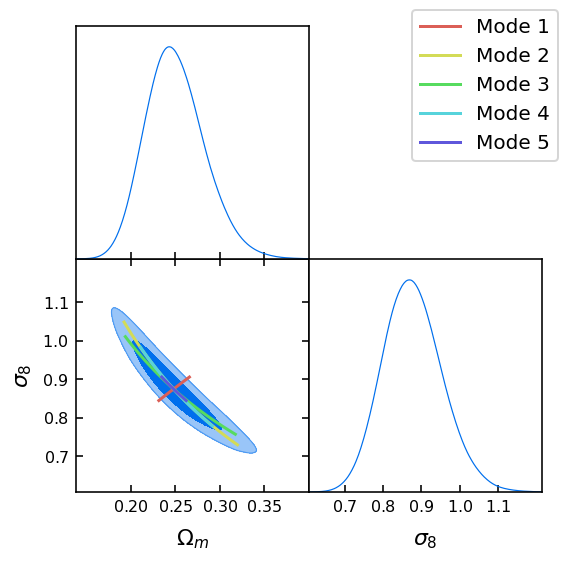

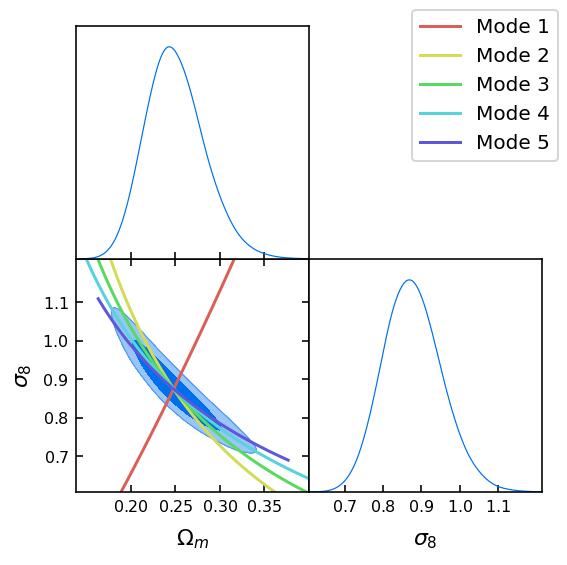

In [94]:
for eigv,title in zip([KL_eigv, PCA_eigv], ['KL','PCA']):
    param_names_plot = ['omegam','sigma8']
    KL_param_names_plot = ['log_'+name for name in param_names_plot]

    param_directions = np.linalg.inv(eigv.T)
    g = plots.get_subplot_plotter()
    g.triangle_plot([chain_gauss], params=param_names_plot, filled=True)
    # add the modes:
    for i in range(len(param_names_plot)-1):
        for j in range(i+1,len(param_names_plot)):
            ax = g.subplots[j,i]\
            # get mean:
            m1, m2 = chain_gauss.getMeans(pars=[chain_gauss.index[name]
                           for name in [KL_param_names_plot[i], KL_param_names_plot[j]]])
            #ax.scatter(np.exp(m1), np.exp(m2), color='k')
            alpha = 3.*np.linspace(-1.,1.,100)
            list_ind = [chain_gauss.index[name]
                           for name in [KL_param_names_plot[i], KL_param_names_plot[j]]]
            i1 = list_ind[0]
            j1 = list_ind[1]
            for k in range(5):

                ax.plot(np.exp(m1+alpha*param_directions[:,k][i1]), np.exp(m2+alpha*param_directions[:,k][j1]), color=sns.hls_palette(6)[k], label='Mode '+str(k+1))
    g.fig.legend(*ax.get_legend_handles_labels())
    
    
    
    